<a href="https://colab.research.google.com/github/DepartmentOfStatisticsPUE/air-2020/blob/master/notebooks/10_analizy_przetrzenne.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Instalacja niezbędnych pakietów

In [0]:
!apt install libspatialindex-dev 
!pip install -U pysal urbanaccess pandana

In [0]:
import numpy as np ## macierze itp 
import pandas as pd  ## ramki danych
import geopandas as gpd ## ramki danych z atrybutami przestrzennymi
import pysal as ps ## macierze, miary Morana itp
import matplotlib.pyplot as plt ## do wykresów
%matplotlib inline 
plt.rcParams['figure.figsize'] = [10, 10] ## wielkosc wykresów


In [3]:
!unzip mapy.zip ## rozpakowujemy folder mapy
!rm -rf __MACOSX ## wywalamy ten folder

Archive:  mapy.zip
   creating: mapy/
  inflating: mapy/powiaty.dbf        
  inflating: mapy/powiaty.shp        
  inflating: mapy/powiaty.shx        
  inflating: mapy/Poznan.dbf         
  inflating: mapy/Poznan.prj         
  inflating: mapy/Poznan.qpj         
  inflating: mapy/Poznan.shp         
  inflating: mapy/Poznan.shx         
  inflating: mapy/woj.dbf            
  inflating: mapy/woj.shp            
  inflating: mapy/woj.shx            


# Miary autokorelacji przestrzennej

## Globalna miara Morana $I$

Statystyka Moran $I$ została nazwana na cześć australijskiego matematyka Patrica Alfreda Pierce'a Morana. Statystyka ta została zaproponowana w 1950 

roku w czasopismie Biometrika i służy do oceny stopnia skorelowania przestrzennego między sąsiadującymi lokalizacjami. 

Aby wyliczyć ten wskaźnik potrzebujemy dwóch informacji:

+ wartości cechy $Y$ dla każdej jednostki przestrzennej $i=1,...,n$,
+ informacji o strukturze sąsiedztwa jednostek, która służy do utworzenia macierzy wag przestrzennych $\mathbf{W}$.

Macierz $\mathbf{W}_{n \times n}$ w przypadku braku standaryzacji ma postać

$$
\mathbf{W} = \begin{bmatrix}
0 & 1 & 0 & 0 \\
1 & 0 & 1 & 1 \\
0 & 1 & 0 & 1 \\
0 & 1 & 1 & 0 
\end{bmatrix}
$$

gdzie elementy tej macierzy określają strukturę sąsiedztwa obiektów. Przykładowo, obiekt 1 graniczy z obiektem 2 więc $\mathbf{W}_{1,2}=\mathbf{W}_{2,1}=1$.

W tej chwili macierz $\mathbf{W}$ jest macierzą niestandaryzowaną i w takim wypadku miara Morana I ma postać:

$$
I = \frac{n}{S_0}\frac{\mathbf{z}^T\mathbf{W}\mathbf{z}}{\mathbf{z}^T\mathbf{z}},
$$

gdzie $\mathbf{z}$ jest wektorem kolumnowym o elementach $z_i=y_i - \bar{y}$ jest wektorem odchyleń wartości cechy $y$ od jej średniej, $n$ oznacza liczbę sąsiadów, a $S_0=\sum_{i=1}^n\sum_{j=1}^nw_{ij}$.

Zwykle jednak stosuje się macierz standaryzowaną wierszowo, gdzie w ramach danego wiersza wartości sumują się do 1. Taką macierz w literaturze oznacza się $\mathbf{W}^*$ i dla powyższego przykładu ma postać:

$$
\mathbf{W}^* = \begin{bmatrix}
0 & 1 & 0 & 0 \\
1/3 & 0 & 1/3 & 1/3 \\
0 & 1/2 & 0 & 1/2 \\
0 & 1/2 & 1/2 & 0 
\end{bmatrix}.
$$

Należy zauważyć, $\mathbf{W}^*$ już nie jest macierzą symetryczną. Zmiania się również statystyka testowa ponieważ $S_0=n$, więc

$$
I = \frac{\mathbf{z}^T\mathbf{W}^*\mathbf{z}}{\mathbf{z}^T\mathbf{z}},
$$

gdzie oznaczenia są takie jak poprzednio.

Rozkład statystyki Morana I jest asymptotycznie normalny i weryfikacja istotności autokorelacji bada się wykorzystujać rozkład normalny standaryzowany, tj.

$$
Z_I = \frac{I-E(I)}{\sqrt{Var(I)}} \sim N(0,1),
$$

gdzie $E(I)$ to wartość oczekiwania statystyki $I$,  a $Var(I)$ to wariancja statystyki dane wzorami

$$
\begin{aligned}
E(I) &= -\frac{1}{n-1},\\
Var(I) &= \frac{n^2S_1-nS_2+3S_0^2}{(n^2-1)S^2_0} - \frac{1}{(n-1)^2},\\
\end{aligned}
$$

gdzie $S_1 = 2(\sum_i\sum_jw_{ij})$, a $S_2=4(\sum_i\sum_jw_{ij})^2$.

Interpretacja uzyskanych wyników opiera się na następujących porównaniach

+ autokorelacja dodatnia $I > -\frac{1}{n-1}$ lub $Z_i > 0$,
+ autokorelacja ujemna $I < - \frac{1}{n-1}$ lub $Z_i < 0$.

## Lokalna miara Morana $I$

Globalna statystyka Morana I ma zastosowanie jeżeli chcemy zweryfikować czy na badanym obszarze występuje autokorelacja cechy $Y$. Czasem jednak interesuje nas inne pytanie. Mianowicie, chcielibyśmy dowiedzieć się o lokalnych skupiskach obiektów podobnych lub obiektów otoczonych obiektami o wysokim lub niskim nasileniu danego zjawiska. 

W takim przypadku stosuje się miary lokalne statystyki autokorelacji przestrzennej (ang. Local Indicators of Spatial Autocorrelation; LISA). Jedną z nich jest lokalna statystyka Morana $I_i$, która jest dana wzorem


$$
I_i = \frac{z_i\sum_{j=1}^nw_{ij}^*z_j}{\sum_{i=1}^nz_i^2},
$$

gdzie oznaczenia są takie jak we wcześniejszych wzorach. Natomiast wartość oczekiwana i wariancja dane są następujacymi wzorami

$$
\begin{aligned}
E(I_i) &= \frac{-\sum_j w_{ij}}{n-1} \\
Var(I_i) & = 
\frac{(n-b_2)\sum_{j \neq i} w_{ij}^2}{n_1} + 
\frac{2(2b_2-n)\sum_{k\neq i}\sum_{h \neq i} w_{ik}w_{ih}}{(n-1)(n-2)} - 
\frac{\left(-\sum_j w_{ij} \right)^2]}{(n-1)^2}
\end{aligned},
$$

gdzie 

$$
b_2 = \frac{m_4}{m_2^2} = \frac{n^{-1}\sum_iz_i^4}{\left( n^{-1} \sum_{i} z_i^2\right)^2}
$$

Podobnie jak statystyka globalna, statystyka lokalna ma również asymptotyczny rozkład normalny

$$
Z_{I_i} = \frac{I_i - E(I_i)}{\sqrt{Var{I_i}}}.
$$


## Literatura

+ Suchecki, B. (Ed.). (2010). Ekonometria przestrzenna: metody i modele analizy danych przestrzennych. Wydawnictwo CH Beck.
+ Moran, P. A. (1950). Notes on continuous stochastic phenomena. Biometrika, 37(1/2), 17-23.




# Autokorelacja przestrzenna w Pythonie -- implementacja w pakiecie `pysal`

W tym celu potrzebujemy dwóch pakietów:

+ geopandas
+ pysal


W pakiecie `pysal` mamy następujące funkcje

+ statystyka globalna: `pysal.explore.esda.moran.Moran(y, w, transformation='r', permutations=999, two_tailed=True)`
+ statystyka lokalna: `pysal.explore.esda.moran.Moran_Local(y, w, transformation='r', permutations=999, geoda_quads=False)`

# Autokorelacja przestrzenna w Pythonie -- przykład empiryczny



Wczytujemy dane o powiatach

In [22]:
pow_df = gpd.read_file("mapy/powiaty.shp")
pow_df.head(n=2)

,SP_ID,iip_przest,iip_identy,iip_wersja,jpt_sjr_ko,jpt_kod_je,jpt_nazwa_,jpt_nazw01,jpt_organ_,jpt_orga01,jpt_jor_id,wazny_od,wazny_do,jpt_wazna_,wersja_od,wersja_do,jpt_powier,jpt_kj_iip,jpt_kj_i01,jpt_kj_i02,jpt_kod_01,id_bufora_,id_bufor01,id_technic,jpt_opis,jpt_sps_ko,gra_ids,status_obi,opis_bledu,typ_bledu,geometry
0,0,PL.PZGIK.200,07f182b1-9146-43e5-a62d-836c211f9ff1,2012-09-27T07:36:28+02:00,POW,0226,powiat zÅotoryjski,None,None,NZN,0.0,None,None,6 NZN,None,2020-12-09,26.0,0000000000EGIB,0226,None,None,0.0,13888.0,0.0,829314,UZG,None,AKTUALNY,None,None,"POLYGON ((269083.616 370884.075, 269164.192 37..."
1,1,PL.PZGIK.200,c845cab0-9fbf-4123-9fc3-c70e57ad17fb,2012-09-27T07:36:28+02:00,POW,0262,powiat Legnica,None,None,NZN,0.0,None,None,6 NZN,None,2020-12-09,26.0,0000000000EGIB,0262,None,None,0.0,13888.0,0.0,829315,UZG,None,AKTUALNY,None,None,"POLYGON ((296226.609 372333.783, 296689.158 37..."


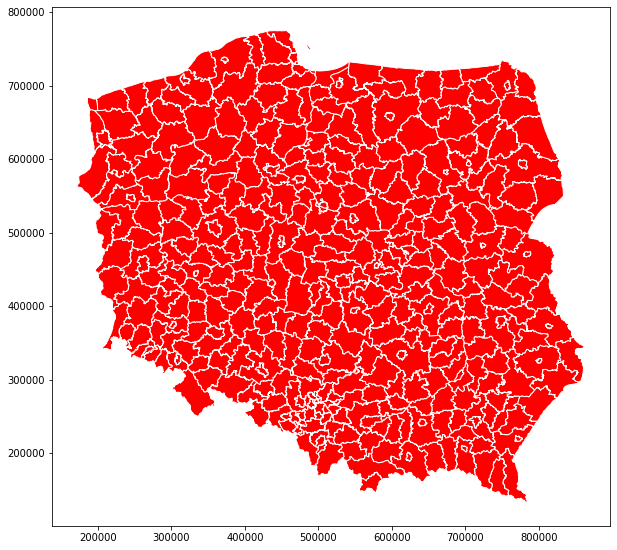

In [13]:
pow_df.plot(color = "red", edgecolor = "white")

Wczytujemy dane o wynagrodzeniach


In [21]:
pow_dane = pd.read_excel("powiaty_wynag.xlsx", sheet_name=1) ## wczytanie danych
pow_dane_sub = pow_dane[["Kod", "Wartosc", "Nazwa"]].copy() ## wybieramy dwie kolumny
pow_dane_sub["kod"]=pow_dane_sub.Kod.astype(str).str.zfill(7) ## zamieniamy na typ znakowy i uzupelniamy zerami
pow_dane_sub["kod"]=pow_dane_sub.kod.str.slice(0,4) ## substring 4 znaki
pow_dane_sub = pow_dane_sub.drop(columns = ["Kod"]) ## usuwamy kolumne Kod
pow_dane_sub

,Wartosc,Nazwa,kod
0,4214.66,Powiat bolesławiecki,0201
1,4024.94,Powiat dzierżoniowski,0202
2,4077.69,Powiat głogowski,0203
3,3815.89,Powiat górowski,0204
4,4029.64,Powiat jaworski,0205
...,...,...,...
375,4045.65,Powiat wałecki,3217
376,4083.38,Powiat łobeski,3218
377,4184.46,Powiat m.Koszalin,3261
378,5007.48,Powiat m.Szczecin,3262


Dodajemy dane o wynagrodzeniach do danych o mapie

In [23]:
pow_df = pd.merge(left = pow_df, right = pow_dane_sub, how = "left", left_on="jpt_kod_je", right_on = "kod")
pow_df.head(n=2)

,SP_ID,iip_przest,iip_identy,iip_wersja,jpt_sjr_ko,jpt_kod_je,jpt_nazwa_,jpt_nazw01,jpt_organ_,jpt_orga01,jpt_jor_id,wazny_od,wazny_do,jpt_wazna_,wersja_od,wersja_do,jpt_powier,jpt_kj_iip,jpt_kj_i01,jpt_kj_i02,jpt_kod_01,id_bufora_,id_bufor01,id_technic,jpt_opis,jpt_sps_ko,gra_ids,status_obi,opis_bledu,typ_bledu,geometry,Wartosc,Nazwa,kod
0,0,PL.PZGIK.200,07f182b1-9146-43e5-a62d-836c211f9ff1,2012-09-27T07:36:28+02:00,POW,0226,powiat zÅotoryjski,None,None,NZN,0.0,None,None,6 NZN,None,2020-12-09,26.0,0000000000EGIB,0226,None,None,0.0,13888.0,0.0,829314,UZG,None,AKTUALNY,None,None,"POLYGON ((269083.616 370884.075, 269164.192 37...",4362.98,Powiat złotoryjski,0226
1,1,PL.PZGIK.200,c845cab0-9fbf-4123-9fc3-c70e57ad17fb,2012-09-27T07:36:28+02:00,POW,0262,powiat Legnica,None,None,NZN,0.0,None,None,6 NZN,None,2020-12-09,26.0,0000000000EGIB,0262,None,None,0.0,13888.0,0.0,829315,UZG,None,AKTUALNY,None,None,"POLYGON ((296226.609 372333.783, 296689.158 37...",4259.37,Powiat m.Legnica,0262


Rysujemy mapę 

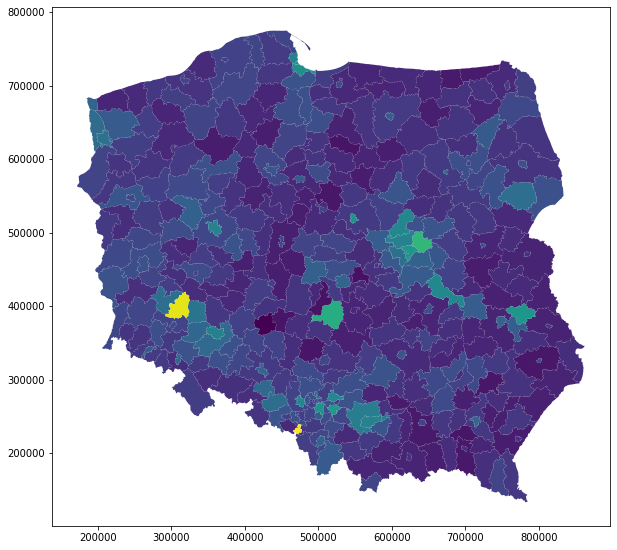

In [24]:
pow_df.plot(column = "Wartosc")

Posortujmy i zobaczmy

In [25]:
pow_df[["kod","Nazwa","Wartosc"]].sort_values(by = "Wartosc", ascending = False)

,kod,Nazwa,Wartosc
276,2467,Powiat m.Jastrzębie-Zdrój,8121.08
28,0211,Powiat lubiński,7915.01
143,1465,Powiat m. st. Warszawa,6432.78
63,1001,Powiat bełchatowski,6259.40
286,2468,Powiat m.Jaworzno,5848.34
...,...,...,...
57,1018,Powiat wieruszowski,3454.23
323,2812,Powiat nowomiejski,3439.34
65,1003,Powiat łaski,3432.41
59,1021,Powiat brzeziński,3385.89


Tworzymy macierz na podstawie danych wejściowych


In [28]:
w=ps.lib.weights.Rook.from_dataframe(pow_df)
w.full()[0]

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Sprawdzamy wartość autokorelacji przestrzennej

In [29]:
 result = ps.explore.esda.moran.Moran(pow_df["Wartosc"], w)
 print([result.I, result.p_norm])

[0.23141858847544294, 8.377076810006656e-12]


Sprawdzmy miary lokalne

In [35]:
np.random.seed(20) ### powtarzalnosc wynikow
result_local = ps.explore.esda.moran.Moran_Local(pow_df["Wartosc"], w, permutations=9999,)
sum(result_local.p_sim < 0.05) ## ile istotnych statystycznie

88

Natysujemy te istotne statystycznie

In [37]:
pow_df["istotne"] = result_local.p_sim < 0.05
pow_df["hots_colds"] = result_local.q
pow_df["hotspots"] = result_local.q == 1 * pow_df["istotne"]
pow_df["coldspots"] = result_local.q == 3 * pow_df["istotne"]
pow_df[["kod","Nazwa","Wartosc", "istotne", "hots_colds"]].head(n = 5)

,kod,Nazwa,Wartosc,istotne,hots_colds
0,0226,Powiat złotoryjski,4362.98,False,4
1,0262,Powiat m.Legnica,4259.37,False,1
2,0206,Powiat jeleniogórski,4035.56,False,2
3,0204,Powiat górowski,3815.89,True,2
4,0214,Powiat oleśnicki,4128.29,False,3


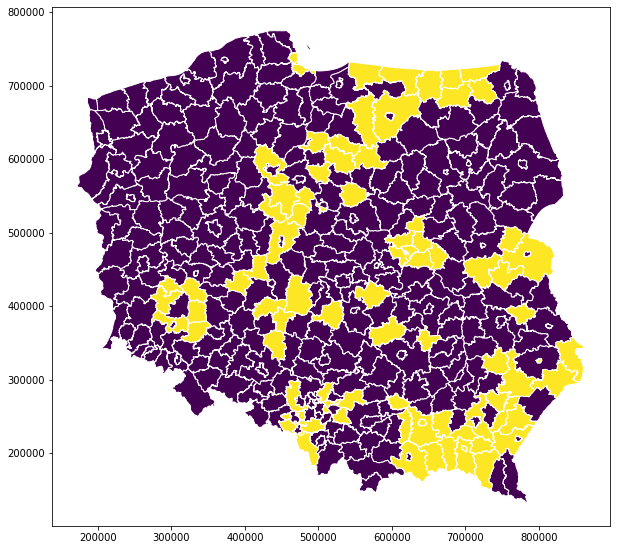

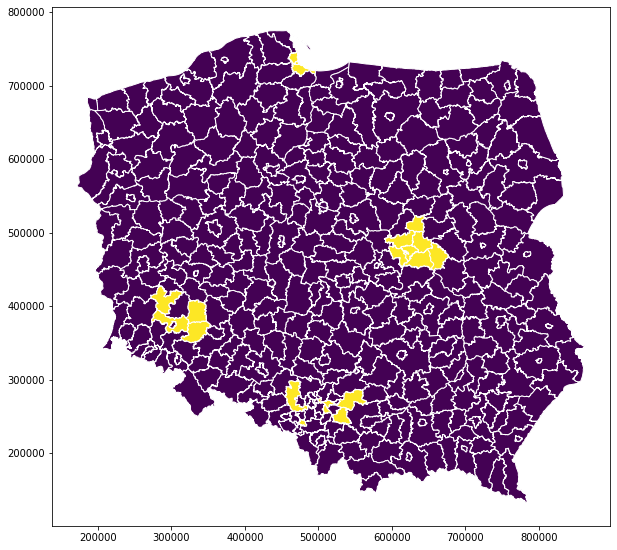

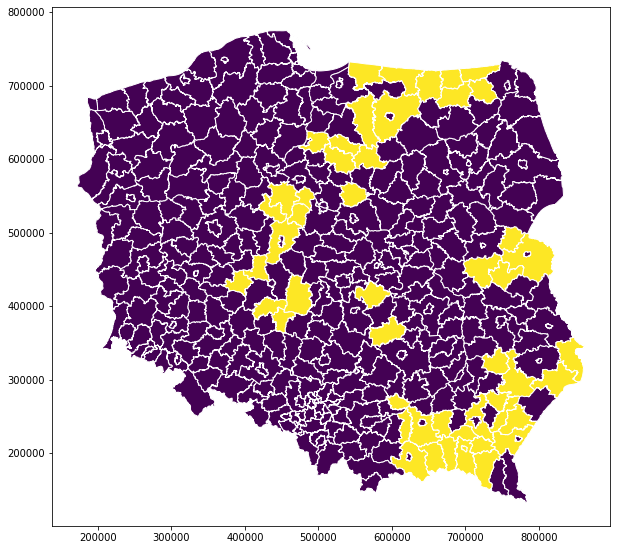

In [38]:
pow_df.plot(column = "istotne", edgecolor = "white")
pow_df.plot(column = "hotspots", edgecolor = "white")
pow_df.plot(column = "coldspots", edgecolor = "white")

# Zadanie

Wykonać to samo ale dla stopy bezrobocia rejestrowanego

# Implementacja własna -- krok po kroku
